### 3D Registration With Fphf & RANSAC
1. This is adapted from [Open3D's example](http://www.open3d.org/docs/release/tutorial/pipelines/global_registration.html) on global registration.
2. The strategy is a two step process. The first step is to extract feature points from both source and target point clouds. The second step involves RANSAC where random voting is used to select surrounding feature points to check for correspondences. 
3. The randomness of RANSAC is desirable as it makes it robust against outliers.Once the correspondences are established, any kind of linear programming can be used to compute the transformation
4. Due to the randomness of voting scheme, the returned result of the same data will be different due to redundant features being available.

In [180]:
import open3d as o3d
import numpy as np
import copy
import time

def draw_registration_result(source, target, transformation, zoom=0.4559, front=[0.6452, -0.3036, -0.7011], lookat=[1.9892, 2.0208, 1.8945], up=[-0.2779, -0.9482, 0.1556]):
    source_temp = copy.deepcopy(source)
    target_temp = copy.deepcopy(target)
    source_temp.paint_uniform_color([1, 0.706, 0])
    target_temp.paint_uniform_color([0, 0.651, 0.929])
    source_temp.transform(transformation)

    # Create line segments to represent coordinate axes
    axis_length = 1.0
    line_set = o3d.geometry.LineSet()
    line_set.points = o3d.utility.Vector3dVector(np.array([[0, 0, 0], [axis_length, 0, 0], [0, axis_length, 0], [0, 0, axis_length]]))
    line_set.lines = o3d.utility.Vector2iVector(np.array([[0, 1], [0, 2], [0, 3]]))
    line_set.colors = o3d.utility.Vector3dVector(np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]]))  # RGB colors for X, Y, Z axes

    o3d.visualization.draw_geometries([source_temp, target_temp, line_set],
                                      zoom=zoom,
                                      front=front,
                                      lookat=lookat,
                                      up=up)
    
def preprocess_point_cloud(pcd, voxel_size):
    start_time = time.perf_counter()
    print(":: Downsample with a voxel size %.3f." % voxel_size)
    pcd_down = pcd.voxel_down_sample(voxel_size)
    end_time = time.perf_counter()
    elapsed_time = end_time - start_time
    print(f"Time taken: {elapsed_time:.6f} seconds")

    start_time = time.perf_counter()
    radius_normal = voxel_size * 2
    print(":: Estimate normal with search radius %.3f." % radius_normal)
    pcd_down.estimate_normals(
        o3d.geometry.KDTreeSearchParamHybrid(radius=radius_normal, max_nn=30))
    end_time = time.perf_counter()
    elapsed_time = end_time - start_time
    print(f"Time taken: {elapsed_time:.6f} seconds")

    start_time = time.perf_counter()
    radius_feature = voxel_size * 5
    print(":: Compute FPFH feature with search radius %.3f." % radius_feature)
    pcd_fpfh = o3d.pipelines.registration.compute_fpfh_feature(
        pcd_down,
        o3d.geometry.KDTreeSearchParamHybrid(radius=radius_feature, max_nn=100))
    end_time = time.perf_counter()
    elapsed_time = end_time - start_time
    print(f"Time taken: {elapsed_time:.6f} seconds")

    return pcd_down, pcd_fpfh

def prepare_dataset(voxel_size):
    print(":: Load two point clouds and disturb initial pose.")

    demo_icp_pcds = o3d.data.DemoICPPointClouds()
    source = o3d.io.read_point_cloud(demo_icp_pcds.paths[0])
    target = o3d.io.read_point_cloud(demo_icp_pcds.paths[1])
    trans_init = np.asarray([[0.0, 0.0, 1.0, 0.0], [1.0, 0.0, 0.0, 0.0],
                             [0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0]])
    source.transform(trans_init)
    draw_registration_result(source, target, np.identity(4))

    # Get the minimum and maximum bounds
    min_bound = source.get_min_bound()
    max_bound = source.get_max_bound()
    print("Minimum bounds:", min_bound)
    print("Maximum bounds:", max_bound)

    source_down, source_fpfh = preprocess_point_cloud(source, voxel_size)
    target_down, target_fpfh = preprocess_point_cloud(target, voxel_size)
    return source, target, source_down, target_down, source_fpfh, target_fpfh

##### Downsample and compute point features

In [181]:
voxel_size = 0.1  # decimation through voxelization. We use 5cm for this dataset
source, target, source_down, target_down, source_fpfh, target_fpfh = prepare_dataset(
    voxel_size
)  # compute fpfh of source and target pc

print(f"# of points, source = {source}, target = {target}")
print(
    f"# of point features, source = {source_fpfh.data.shape}, target = {target_fpfh.data.shape}"
)

:: Load two point clouds and disturb initial pose.
Minimum bounds: [0.55859375 0.55078125 0.83203125]
Maximum bounds: [2.5536561  3.9607718  2.42490005]
:: Downsample with a voxel size 0.100.
Time taken: 0.010826 seconds
:: Estimate normal with search radius 0.200.
Time taken: 0.011830 seconds
:: Compute FPFH feature with search radius 0.500.
Time taken: 0.020755 seconds
:: Downsample with a voxel size 0.100.
Time taken: 0.008438 seconds
:: Estimate normal with search radius 0.200.
Time taken: 0.000917 seconds
:: Compute FPFH feature with search radius 0.500.
Time taken: 0.013782 seconds
# of points, source = PointCloud with 198835 points., target = PointCloud with 137833 points.
# of point features, source = (33, 1301), target = (33, 914)


##### RANSAC
1. Random sample consensus is an iterative method to estimate parameters of a mathematical model from a set of observed data that contains outliers, when outliers are to be accorded no influence on the values of the estimates
2. Psuedocode can be found from [here](https://en.wikipedia.org/wiki/Random_sample_consensus)

In [182]:
def execute_global_registration(source_down, target_down, source_fpfh,
                                target_fpfh, voxel_size):
    distance_threshold = voxel_size * 1.5
    print(":: RANSAC registration on downsampled point clouds.")
    print("   Since the downsampling voxel size is %.3f," % voxel_size)
    print("   we use a liberal distance threshold %.3f." % distance_threshold)
    result = o3d.pipelines.registration.registration_ransac_based_on_feature_matching(
        source_down, target_down, source_fpfh, target_fpfh, True,
        distance_threshold,
        o3d.pipelines.registration.TransformationEstimationPointToPoint(False),
        3, [
            o3d.pipelines.registration.CorrespondenceCheckerBasedOnEdgeLength(
                0.9),
            o3d.pipelines.registration.CorrespondenceCheckerBasedOnDistance(
                distance_threshold)
        ], o3d.pipelines.registration.RANSACConvergenceCriteria(100000, 0.999))
    return result

start_time = time.perf_counter()
result_ransac = execute_global_registration(source_down, target_down,
                                            source_fpfh, target_fpfh,
                                            voxel_size)
end_time = time.perf_counter()
elapsed_time = end_time - start_time

print(result_ransac)
print(f"Time taken for RANSAC: {elapsed_time:.6f} seconds")
print(f"Transformation = \n{result_ransac.transformation}")

draw_registration_result(source_down, target_down, result_ransac.transformation)

:: RANSAC registration on downsampled point clouds.
   Since the downsampling voxel size is 0.100,
   we use a liberal distance threshold 0.150.
RegistrationResult with fitness=6.733282e-01, inlier_rmse=6.247739e-02, and correspondence_set size of 876
Access transformation to get result.
Time taken for RANSAC: 0.039460 seconds
Transformation = 
[[-0.477864    0.87822148  0.01931402  0.43011192]
 [-0.28304515 -0.17475229  0.943052    0.98025501]
 [ 0.8315837   0.44518386  0.33208416 -1.42009317]
 [ 0.          0.          0.          1.        ]]


RANSAC can result in unexpected pose mismatch

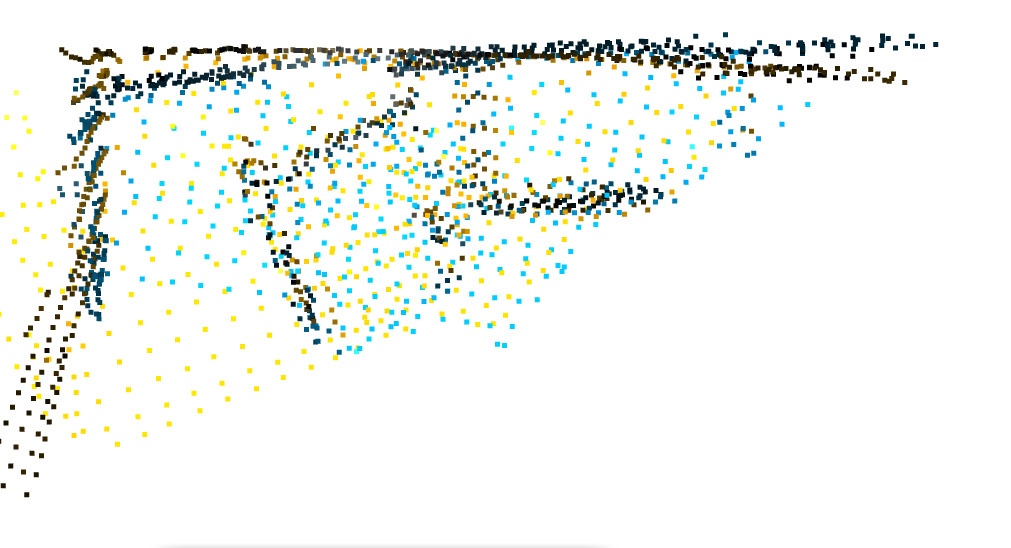